In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
import math
from sklearn.metrics import mean_squared_error


In [45]:

# Load the CSV data
df = pd.read_csv('./data/cleaned_weekly_stock_market.csv')

# Filter the data for "AMEN BANK"
amen_bank = df[df['companyName'] == 'AMEN BANK']

# Extract closing prices
amen_bank = amen_bank.reset_index()['closingPrice']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(amen_bank).reshape(-1,1))

# Split the data into training and testing sets
training_size = int(len(scaled_data) * 0.70)  # Increase training size
test_size = len(scaled_data) - training_size
train_data, test_data = scaled_data[0:training_size,:], scaled_data[training_size:len(scaled_data),:1]

# Function to create a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Create datasets
time_step = 15  # Increase time step
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model with dropout for regularization
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


/home/firas/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 15, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,701 (787.89 KB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32, verbose=1)  # Adjust epochs and batch size


Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0117 - val_loss: 0.0487
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0031 - val_loss: 0.0240
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0026 - val_loss: 0.0134
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0026 - val_loss: 0.0217
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0023 - val_loss: 0.0172
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019 - val_loss: 0.0099
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0018 - val_loss: 0.0076
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0017 - val_loss: 0.0089
Epoch 9/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 0.0140
Epoch 10/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 11/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0016 - val_loss: 0.0088
Epoch 12/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/st

In [47]:

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Train RMSE: 21.85214007203231
Test RMSE: 27.644141214840634


ValueError: x and y must have same first dimension, but have shapes (99,) and (100, 1)

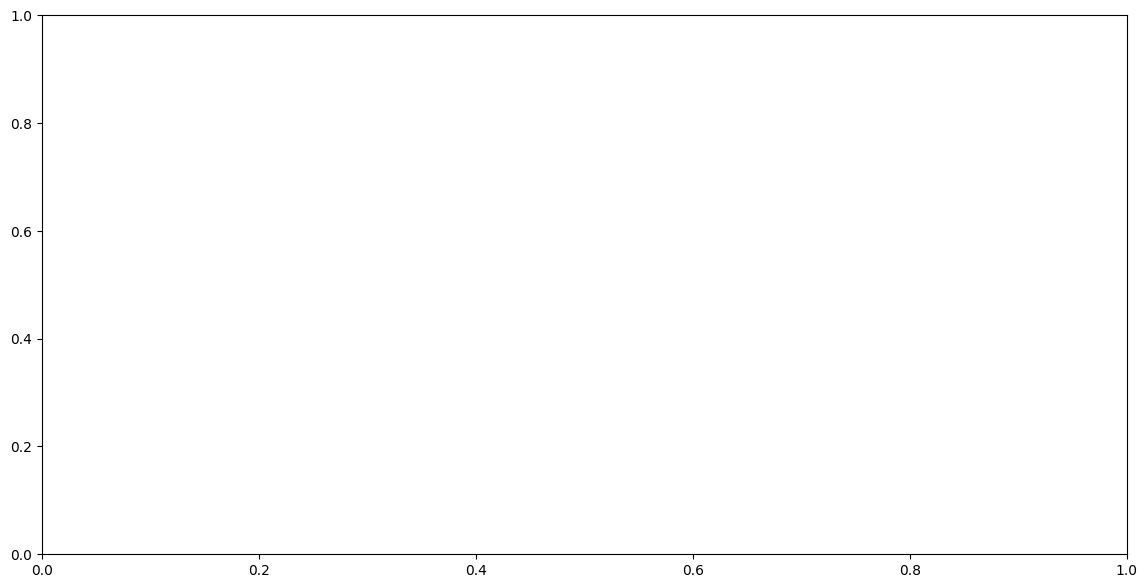

In [48]:

# Predict the next 10 days
n_steps = time_step
x_input = test_data[len(test_data)-n_steps:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
for i in range(10):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

# Plot the last 100 actual values and the predicted values for the next 10 days
plt.figure(figsize=(14, 7))
plt.plot(day_new, scaler.inverse_transform(scaled_data[len(scaled_data)-100:]), label='Actual Values') #type: ignore
plt.plot(day_pred, scaler.inverse_transform(lst_output), label='Predicted Values for Next 10 Days') #type: ignore
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Full visualization including all data points and predictions
stock_pred = scaled_data.tolist()
stock_pred.extend(lst_output)
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(stock_pred), label='Full Series with Predictions')
plt.title('Full Stock Price Series with Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
